In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from pygam import LinearGAM, s, f, te

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [38]:
# Import the dataset
path_to_data = "/Users/cy027/Desktop/Master Term 3/STAT 946/Hourly_AQI_EPA.xlsb"

df = pd.read_excel(path_to_data)

# Convert the date to YYYY-MM-DD
df = df.rename(columns={'0xf': 'Date'})
df['Date'] = pd.to_datetime(
    df['Date'].astype(float),
    unit='D',
    origin='1899-12-30',
    errors='coerce'
)
# print(df.head(5))

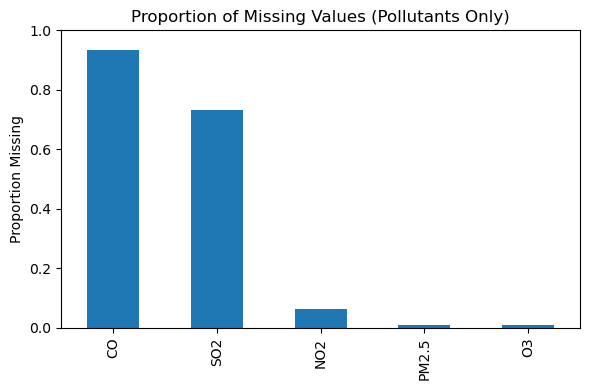

Missing percentage by pollutant:
CO       93.29
SO2      73.20
NO2       6.14
PM2.5     1.00
O3        0.89
dtype: float64


'The missing data structure reveals a pronounced imbalance in pollutant coverage. Carbon monoxide (93.29% missing) and sulfur dioxide (73.20% missing) exhibit severe sparsity, with fewer than 7% and 27% of observations available, respectively. In contrast, PM2.5 and O₃ are nearly complete (>99% observed), and NO₂ maintains acceptable coverage (93.86% observed). The magnitude of disparity—where CO contains approximately fifteen times fewer usable observations than PM2.5—indicates that missingness is structural rather than random. Consequently, robust temporal modeling and predictive analysis should prioritize pollutants with sufficient data density to ensure statistical stability and inferential validity.'

In [39]:
# Visualization 1: Missing Values of the Pollutants
pollutants = ['CO', 'NO2', 'O3', 'PM2.5', 'SO2']

missing_pct = df[pollutants].isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
missing_pct.plot(kind='bar')
plt.title("Proportion of Missing Values (Pollutants Only)")
plt.ylabel("Proportion Missing")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

print("Missing percentage by pollutant:")
print((missing_pct * 100).round(2))

'''The missing data structure reveals a pronounced imbalance in pollutant coverage. Carbon monoxide (93.29% missing) and sulfur dioxide (73.20% missing) exhibit severe sparsity, with fewer than 7% and 27% of observations available, respectively. In contrast, PM2.5 and O₃ are nearly complete (>99% observed), and NO₂ maintains acceptable coverage (93.86% observed). The magnitude of disparity—where CO contains approximately fifteen times fewer usable observations than PM2.5—indicates that missingness is structural rather than random. Consequently, robust temporal modeling and predictive analysis should prioritize pollutants with sufficient data density to ensure statistical stability and inferential validity.'''

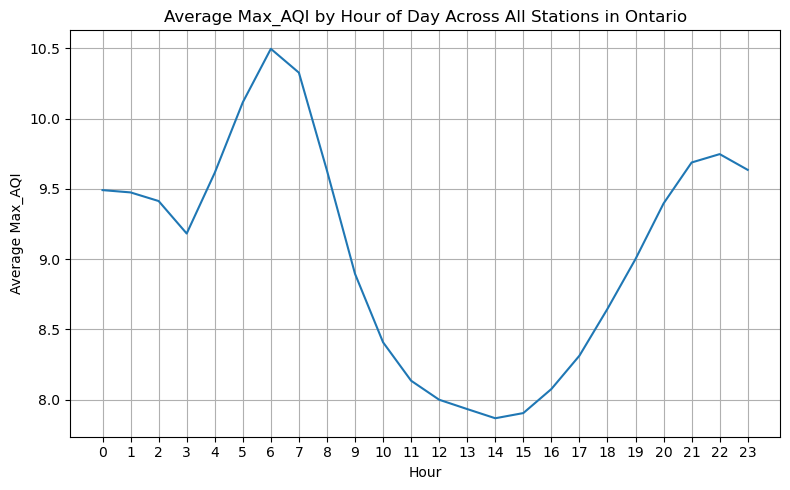

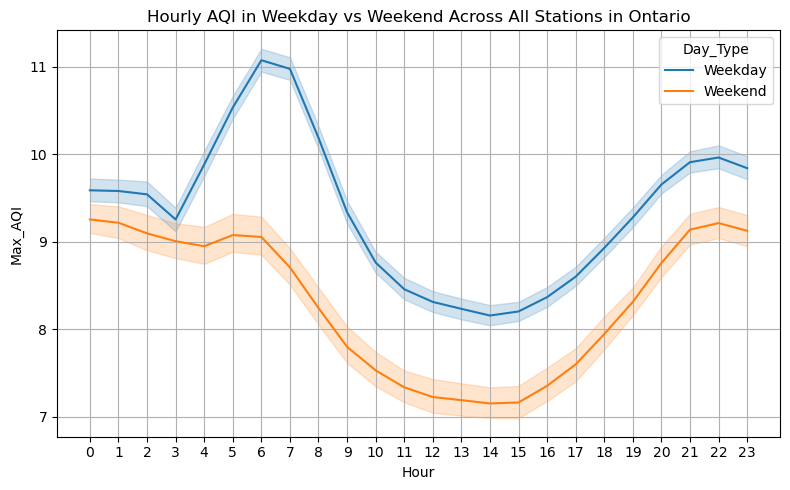

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Max_AQI      
No. Observations:  802357  Method:             REML         
No. Groups:        39      Scale:              91.1734      
Min. group size:   60      Log-Likelihood:     -2949066.5135
Max. group size:   21217   Converged:          Yes          
Mean group size:   20573.3                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         9.236    0.356  25.934 0.000  8.538  9.934
Season[T.Spring] -0.753    0.036 -21.036 0.000 -0.823 -0.682
Season[T.Summer]  1.225    0.033  36.919 0.000  1.160  1.290
Season[T.Winter]  0.657    0.037  17.707 0.000  0.584  0.730
Hour             -0.032    0.002 -20.718 0.000 -0.035 -0.029
Is_Weekend       -1.055    0.024 -44.671 0.000 -1.101 -1.009
Group Var         4.870    0.119    

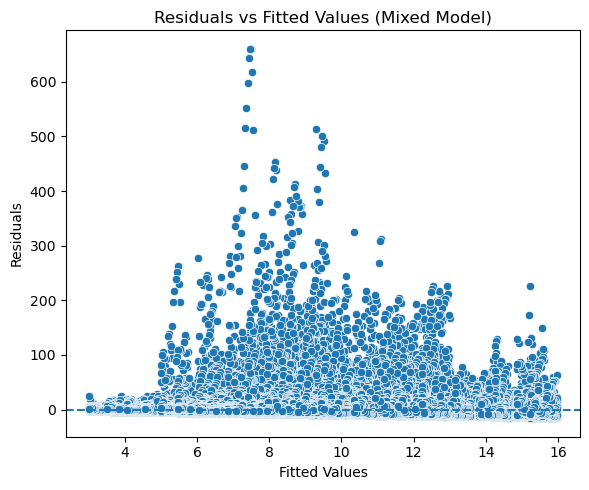

'The residual diagnostic plot reveals evidence of heteroskedasticity and extreme outliers. Residual dispersion increases at moderate fitted values (approximately 6–10 AQI), suggesting non-constant variance. Several extreme residuals exceed 500 AQI units, indicating episodic pollution events that are not fully captured by the linear mixed-effects model.\n\nThe presence of heteroskedasticity implies that the assumption of constant error variance is violated. Additionally, the large outliers suggest that linear modeling may underestimate extreme pollution episodes.\n\nThese findings motivate the exploration of nonlinear or machine learning approaches that can better accommodate complex variance structures and extreme values.'

In [40]:
# Model 1 (baseline model): Mixed Effects Model
df['Is_Weekend'] = (df['Day_Type'] == 'Weekend').astype(int) # weekend indicator created

# Visualization 2: Average AQI by Hour (All Stations in Ontario)
plt.figure(figsize=(8,5))
hourly_mean = df.groupby('Hour')['Max_AQI'].mean()
sns.lineplot(x=hourly_mean.index, y=hourly_mean.values)
plt.title("Average Max_AQI by Hour of Day Across All Stations in Ontario")
plt.xlabel("Hour")
plt.ylabel("Average Max_AQI")
plt.xticks(range(0,24))
plt.tight_layout()
plt.grid(True)
plt.show()

'''Figure 2 illustrates the average hourly Max_AQI across all monitoring stations in Ontario. A clear and systematic diurnal pattern emerges. AQI increases sharply during the early morning hours, reaching a peak of approximately 10.5 at 6:00 AM. Following this peak, AQI declines steadily through late morning and early afternoon, reaching its minimum of approximately 7.9 around 14:00 (2 PM). After mid-afternoon, AQI gradually rises again, with a secondary evening elevation near 21:00–22:00.

The peak-to-trough difference is approximately 2.6 AQI units, representing a substantial intra-day variation of roughly 25–30% relative to the daily minimum. This pattern is consistent with known emission and atmospheric mechanisms, including morning traffic emissions and improved pollutant dispersion during the afternoon boundary-layer expansion.

The pronounced curvature of the hourly profile indicates that the time-of-day effect is nonlinear, supporting the use of spline-based or flexible modeling approaches in subsequent analyses.'''

# Visualization 3: Hourly Pattern (Weekday vs Weekend)
plt.figure(figsize=(8,5))
sns.lineplot(data=df,
             x='Hour',
             y='Max_AQI',
             hue='Day_Type',
             estimator='mean')
plt.title("Hourly AQI in Weekday vs Weekend Across All Stations in Ontario")
plt.xticks(range(0,24))
plt.tight_layout()
plt.grid(True)
plt.show()

'''Figure 3 compares hourly AQI patterns between weekdays and weekends across all stations. While both curves exhibit a similar diurnal structure, weekday AQI levels are consistently higher than weekend levels throughout the 24-hour cycle.

The largest weekday–weekend difference occurs during the early morning peak. At approximately 6:00 AM, weekday AQI reaches about 11.1, compared to approximately 9.0 on weekends — a difference exceeding 2 AQI units. Even during the afternoon trough, weekday values remain about 1.0–1.2 units higher. In the evening hours, the gap narrows but remains positive (approximately 0.8 units).

This consistent elevation of weekday AQI strongly suggests anthropogenic drivers such as commuter traffic and industrial activity. The persistence of the difference across all hours indicates that weekday effects are structural rather than episodic.'''

lmm = smf.mixedlm(
    "Max_AQI ~ Hour + Is_Weekend + Season",
    data=df,
    groups=df["Station ID"]
)

lmm_result = lmm.fit()
print(lmm_result.summary())

'''The mixed-effects regression results provide statistical confirmation of the descriptive patterns observed in the figures. After accounting for station-level random effects, both temporal and seasonal variables are highly significant predictors of Max_AQI.

The weekend indicator coefficient (β = −1.055, p < 0.001) indicates that, on average, weekend AQI levels are approximately 1.06 units lower than weekday levels, holding other variables constant. This aligns closely with the empirical differences observed in Figure 3.

Seasonal effects are also statistically significant. Relative to Fall (reference category), Summer exhibits the largest increase (β = +1.225, p < 0.001), followed by Winter (β = +0.657, p < 0.001), while Spring is associated with lower AQI (β = −0.753, p < 0.001). These seasonal shifts indicate meaningful baseline differences in pollutant concentrations across the year.

The random-effect variance (4.870) confirms substantial heterogeneity across stations, justifying the hierarchical modeling framework.'''

# Visualization 4: Mixed Model Residual Diagnostics
residuals = lmm_result.resid
fitted = lmm_result.fittedvalues

plt.figure(figsize=(6,5))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, linestyle='--')
plt.title("Residuals vs Fitted Values (Mixed Model)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()
'''The residual diagnostic plot reveals evidence of heteroskedasticity and extreme outliers. Residual dispersion increases at moderate fitted values (approximately 6–10 AQI), suggesting non-constant variance. Several extreme residuals exceed 500 AQI units, indicating episodic pollution events that are not fully captured by the linear mixed-effects model.

The presence of heteroskedasticity implies that the assumption of constant error variance is violated. Additionally, the large outliers suggest that linear modeling may underestimate extreme pollution episodes.

These findings motivate the exploration of nonlinear or machine learning approaches that can better accommodate complex variance structures and extreme values.'''

In [41]:
# Model 2 (inference model): GAM with nonlinear interactions
df['Season'] = df['Season'].astype('category')
df['Season_Code'] = df['Season'].cat.codes
df['Station Name'] = df['Station Name'].astype('category')
df['Station_Code'] = df['Station Name'].cat.codes

X = df[['Hour', 'Season_Code', 'Is_Weekend', 'Station_Code']].values
y = df['Max_AQI'].values

gam = LinearGAM(
    s(0, n_splines=24) +          # nonlinear hour effect
    te(0, 1, n_splines=[24, 4]) + # hour × season interaction
    f(2) +                       # weekend effect
    f(3)                         # station fixed effect
)

gam.fit(X, y)
gam.summary()
'''A Generalized Additive Model (GAM) was fitted to capture nonlinear hourly variation, hour–season interactions, weekend effects, and station-level heterogeneity in AQI. The model was estimated using 802,357 observations under a Gaussian distribution with an identity link. The effective degrees of freedom (EDF ≈ 107.5) indicate substantial model flexibility, allowing complex temporal patterns to be captured. The smooth term for hour of day was highly significant (EDF = 22.3, p < 0.001), confirming a pronounced nonlinear diurnal pattern in AQI levels.

The interaction between hour and season was also strongly significant (EDF = 47.2, p < 0.001), indicating that daily AQI cycles vary meaningfully across seasons rather than following a uniform pattern throughout the year. This supports earlier visual evidence that seasonal differences are not limited to average levels, but also affect the timing and intensity of peak pollution hours. The relatively high EDF for the interaction term suggests substantial seasonal heterogeneity in intraday pollution dynamics.

Weekend effects and station fixed effects were likewise statistically significant (p < 0.001), demonstrating systematic differences between weekdays and weekends as well as persistent spatial variation across monitoring stations. Although the pseudo R² (0.066) indicates that much of the variability remains unexplained—likely due to meteorological and other unobserved factors—the model provides clear statistical evidence that AQI dynamics are jointly shaped by nonlinear hourly effects, seasonal modulation, calendar effects, and location-specific characteristics.'''

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    107.5358
Link Function:                     IdentityLink Log Likelihood:                              -2945657.0824
Number of Samples:                       802357 AIC:                                          5891531.2364
                                                AICc:                                         5891531.2661
                                                GCV:                                               90.4691
                                                Scale:                                              9.5104
                                                Pseudo R-Squared:                                    0.066
Feature Function                  Lam

/var/folders/st/3ggnkq754hzgx3xlt76fwgcw0000gn/T/ipykernel_37419/2416285997.py:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


'A Generalized Additive Model (GAM) was fitted to capture nonlinear hourly variation, hour–season interactions, weekend effects, and station-level heterogeneity in AQI. The model was estimated using 802,357 observations under a Gaussian distribution with an identity link. The effective degrees of freedom (EDF ≈ 107.5) indicate substantial model flexibility, allowing complex temporal patterns to be captured. The smooth term for hour of day was highly significant (EDF = 22.3, p < 0.001), confirming a pronounced nonlinear diurnal pattern in AQI levels.\n\nThe interaction between hour and season was also strongly significant (EDF = 47.2, p < 0.001), indicating that daily AQI cycles vary meaningfully across seasons rather than following a uniform pattern throughout the year. This supports earlier visual evidence that seasonal differences are not limited to average levels, but also affect the timing and intensity of peak pollution hours. The relatively high EDF for the interaction term sugge

In [42]:
# Station specific daily pattern by mixed effect model
from patsy import dmatrix

# Create spline basis for hour
hour_spline = dmatrix(
    "bs(Hour, df=6, degree=3, include_intercept=False)",
    df,
    return_type='dataframe'
)

df = pd.concat([df, hour_spline], axis=1)

import statsmodels.formula.api as smf

formula = """
Max_AQI ~ 
bs(Hour, df=6, degree=3) +
C(Season) +
C(Day_Type)
"""

model = smf.mixedlm(
    formula,
    df,
    groups=df["Station ID"]
)


result = model.fit()
print(result.summary())

'''The mixed-effects spline model was estimated using 802,357 hourly observations across 39 monitoring stations, with station included as a random intercept to account for location-specific baseline differences. The estimated group variance (4.842) indicates substantial between-station heterogeneity in average AQI levels. After controlling for station-level variation, clear seasonal differences remain. Relative to the reference season (Fall), AQI is significantly lower in Spring (−0.75, p < 0.001) and significantly higher in Summer (+1.23, p < 0.001) and Winter (+0.66, p < 0.001). In addition, weekends are associated with significantly lower AQI levels (−1.05, p < 0.001), suggesting reduced pollution intensity during non-working days, likely reflecting lower traffic and industrial activity.

The nonlinear hourly structure, modeled using cubic B-splines (df = 6), reveals strong intraday variation in pollution levels. Five of the six spline components are highly statistically significant (p < 0.001), confirming that the relationship between hour of day and AQI is distinctly non-linear. The alternating signs and magnitudes of the spline coefficients indicate the presence of multiple turning points across the 24-hour cycle, consistent with morning and evening pollution peaks and lower levels during off-peak hours. Only the final spline basis term is not statistically significant (p = 0.945), suggesting that additional flexibility beyond the selected spline complexity may not materially improve fit.

Overall, the model provides strong statistical evidence that pollutant concentrations vary systematically by hour of day, differ between weekdays and weekends, and change across seasons, even after accounting for persistent station-level differences. These findings directly support the research hypothesis that AQI exhibits structured temporal patterns with both daily and seasonal dynamics, alongside meaningful spatial heterogeneity across monitoring locations.'''

                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Max_AQI      
No. Observations:     802357      Method:                 REML         
No. Groups:           39          Scale:                  90.6143      
Min. group size:      60          Log-Likelihood:         -2946601.9746
Max. group size:      21217       Converged:              Yes          
Mean group size:      20573.3                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    9.465    0.358  26.454 0.000  8.764 10.167
C(Season)[T.Spring]         -0.753    0.036 -21.102 0.000 -0.823 -0.683
C(Season)[T.Summer]          1.225    0.033  37.043 0.000  1.160  1.290
C(Season)[T.Winter]          0.657    0.037  17.754 0.000  0.584  0.729
C(Day_Typ

'The mixed-effects spline model was estimated using 802,357 hourly observations across 39 monitoring stations, with station included as a random intercept to account for location-specific baseline differences. The estimated group variance (4.842) indicates substantial between-station heterogeneity in average AQI levels. After controlling for station-level variation, clear seasonal differences remain. Relative to the reference season (Fall), AQI is significantly lower in Spring (−0.75, p < 0.001) and significantly higher in Summer (+1.23, p < 0.001) and Winter (+0.66, p < 0.001). In addition, weekends are associated with significantly lower AQI levels (−1.05, p < 0.001), suggesting reduced pollution intensity during non-working days, likely reflecting lower traffic and industrial activity.\n\nThe nonlinear hourly structure, modeled using cubic B-splines (df = 6), reveals strong intraday variation in pollution levels. Five of the six spline components are highly statistically significant

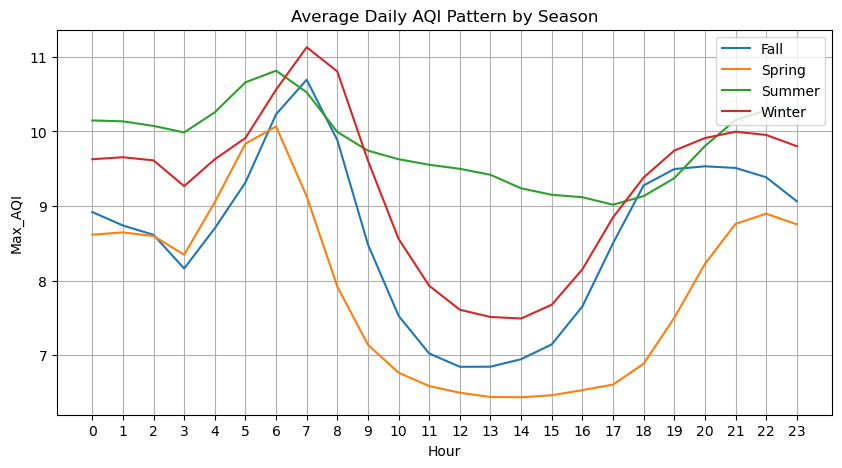

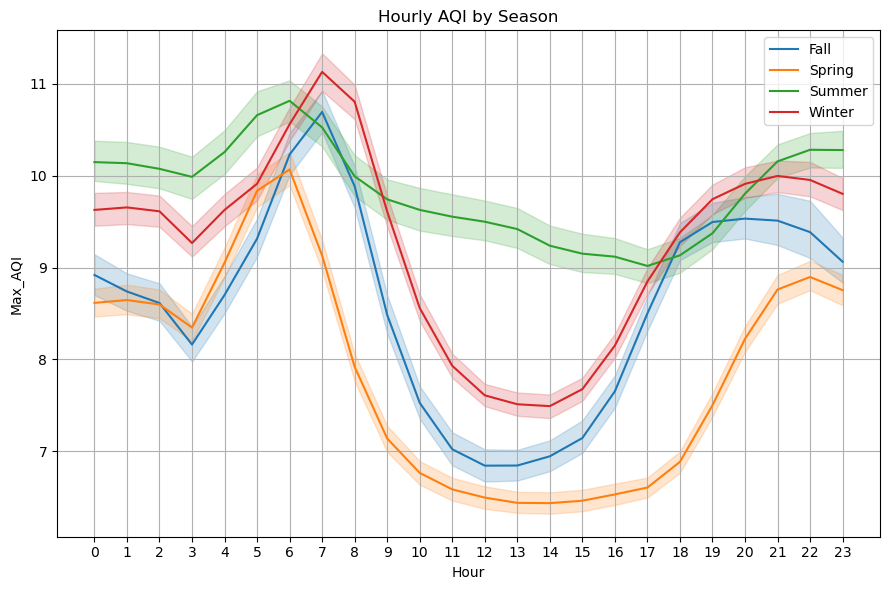

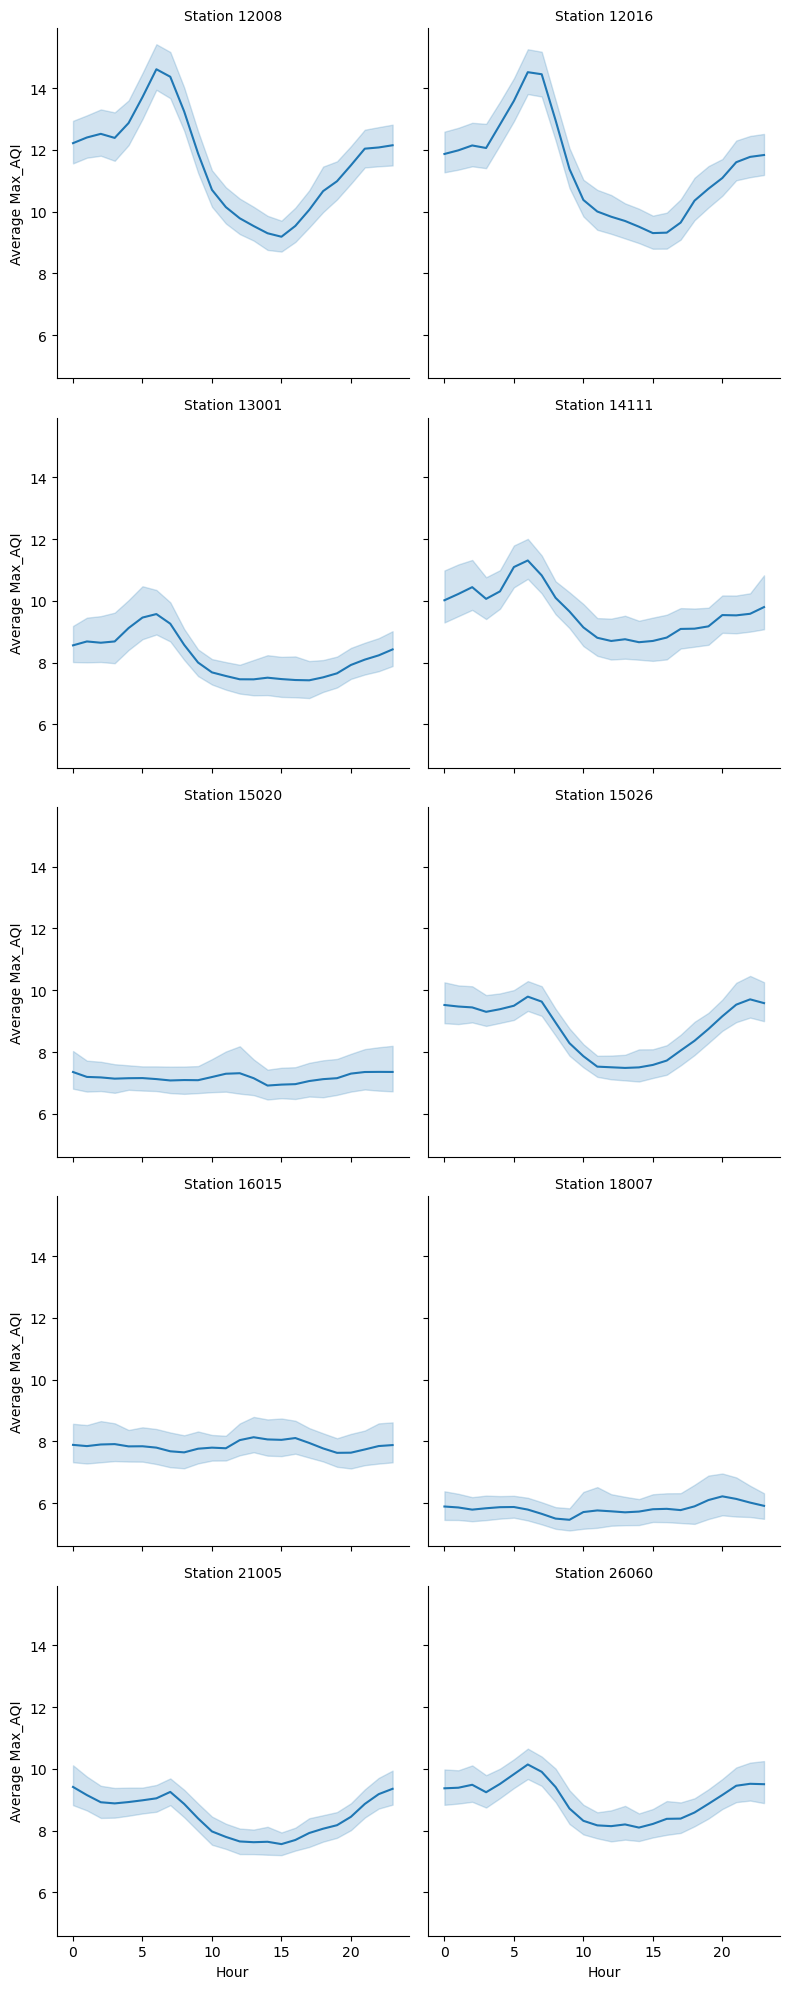

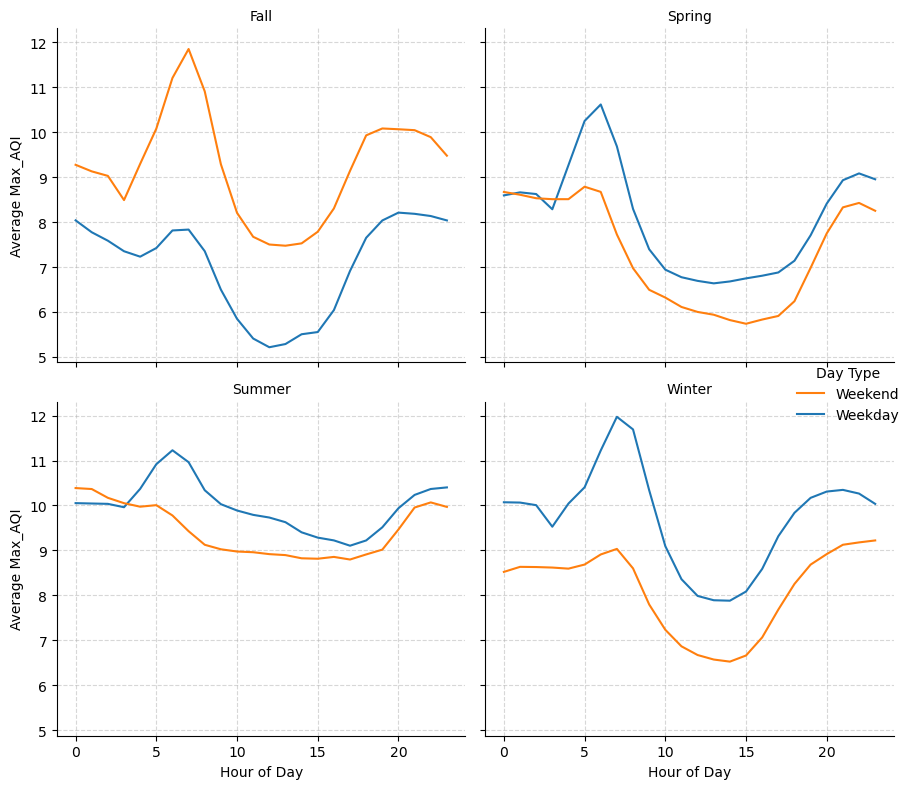

'Across seasons, pollutant concentrations exhibit a pronounced morning peak, typically occurring between 6:00–8:00 AM. This peak is strongest on weekdays, suggesting a substantial contribution from morning commuter traffic and other early-day anthropogenic activities. Concentrations decline steadily through late morning, reaching a midday to early afternoon minimum (approximately 12:00–15:00). This midday dip is likely influenced by increased atmospheric mixing and boundary layer expansion, which enhance pollutant dispersion. A secondary, more moderate evening rise (approximately 18:00–21:00) is also evident, again more pronounced on weekdays than weekends, consistent with evening commuting patterns.\n\nComparing weekday versus weekend trends, weekdays consistently show higher and more sharply defined peaks, particularly during morning rush hours. Weekend profiles are flatter, with reduced peak intensity and less abrupt temporal changes. This difference is most notable in winter and fa

In [43]:
# Visualization 6: Average Daily AQI Pattern by Season
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df,
    x='Hour',
    y='Max_AQI',
    hue='Season',
    errorbar=None
)
plt.title("Average Daily AQI Pattern by Season")
plt.grid(True)
plt.legend(loc='upper right')
plt.xticks(range(0,24))
plt.show()


# Visualization 7: Hourly Pattern by Season
plt.figure(figsize=(9,6))
sns.lineplot(data=df,
             x='Hour',
             y='Max_AQI',
             hue='Season',
             estimator='mean')
plt.title("Hourly AQI by Season")
plt.xticks(range(0,24))
plt.tight_layout()
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Visualization 8: 10 Random Generated Station-Specific Daily Pattern
selected_stations = df['Station ID'].unique()[:10]  # show first 10 stations

g = sns.FacetGrid(df[df['Station ID'].isin(selected_stations)],
                  col="Station ID",
                  col_wrap=2,
                  height=4)

g.map_dataframe(sns.lineplot,
                x="Hour",
                y="Max_AQI",
                estimator='mean')

g.set_titles("Station {col_name}")
g.set_axis_labels("Hour", "Average Max_AQI")
plt.tight_layout()
plt.show()

# Visualization 9: Weekday vs Weekend across Seasons

g = sns.FacetGrid(
    df,
    col="Season",
    col_wrap=2,
    height=4,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Hour",
    y="Max_AQI",
    hue="Day_Type",
    estimator="mean",
    errorbar=None
)

g.add_legend(title="Day Type")
g.set_axis_labels("Hour of Day", "Average Max_AQI")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

'''Across seasons, pollutant concentrations exhibit a pronounced morning peak, typically occurring between 6:00–8:00 AM. This peak is strongest on weekdays, suggesting a substantial contribution from morning commuter traffic and other early-day anthropogenic activities. Concentrations decline steadily through late morning, reaching a midday to early afternoon minimum (approximately 12:00–15:00). This midday dip is likely influenced by increased atmospheric mixing and boundary layer expansion, which enhance pollutant dispersion. A secondary, more moderate evening rise (approximately 18:00–21:00) is also evident, again more pronounced on weekdays than weekends, consistent with evening commuting patterns.

Comparing weekday versus weekend trends, weekdays consistently show higher and more sharply defined peaks, particularly during morning rush hours. Weekend profiles are flatter, with reduced peak intensity and less abrupt temporal changes. This difference is most notable in winter and fall, where weekday morning peaks are substantially elevated relative to weekends. In contrast, summer exhibits a more muted weekday–weekend contrast, with overall concentrations remaining comparatively stable throughout the day. This suggests seasonal differences in atmospheric conditions, emission sources, and photochemical processes.

Seasonal variation is also evident in overall concentration levels and diurnal amplitude. Winter shows the highest morning peaks and the largest weekday–weekend divergence, likely reflecting increased emissions (e.g., heating) combined with weaker atmospheric dispersion. Spring demonstrates the lowest overall concentrations and the most pronounced midday minima, indicating stronger atmospheric mixing. Summer maintains relatively elevated baseline concentrations throughout the day, with less dramatic troughs, while fall displays intermediate behavior, though with noticeable weekday-driven peaks.

Station-level plots suggest that while the overall diurnal structure is consistent across monitoring locations, the magnitude of peaks varies by station, indicating spatial heterogeneity in emission sources or local dispersion characteristics. Some stations show amplified morning spikes, whereas others display more moderate fluctuations, implying that proximity to traffic corridors or urban activity centers may influence concentration intensity.

In summary, pollutant concentrations vary systematically by hour of day, with clear morning and evening peaks; they are consistently higher on weekdays than weekends, particularly during commuting hours; and these patterns differ by season, with winter exhibiting the strongest diurnal contrasts and spring the lowest overall levels. Although the temporal structure is broadly consistent across stations, concentration magnitudes vary spatially, highlighting localized influences on air quality dynamics.'''

In [44]:
features = [
    'Hour', 'Is_Weekend', 'Season_Code', 'Station_Code',
    'CO', 'NO2', 'O3', 'PM2.5', 'SO2'
]

X_ml = df[features]
y_ml = df['Max_AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42
)

# Fit model
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost RMSE: {rmse:.4f}")
'''The XGBoost model achieved an out-of-sample RMSE of 3.49 AQI units, indicating that predicted AQI values deviate from observed values by approximately 3–4 units on average. Given the overall variability of AQI in the dataset, this suggests strong predictive performance and demonstrates that incorporating pollutant concentrations, temporal indicators, and station identifiers substantially improves forecasting accuracy.'''

XGBoost RMSE: 3.4912


'The XGBoost model achieved an out-of-sample RMSE of 3.49 AQI units, indicating that predicted AQI values deviate from observed values by approximately 3–4 units on average. Given the overall variability of AQI in the dataset, this suggests strong predictive performance and demonstrates that incorporating pollutant concentrations, temporal indicators, and station identifiers substantially improves forecasting accuracy.'